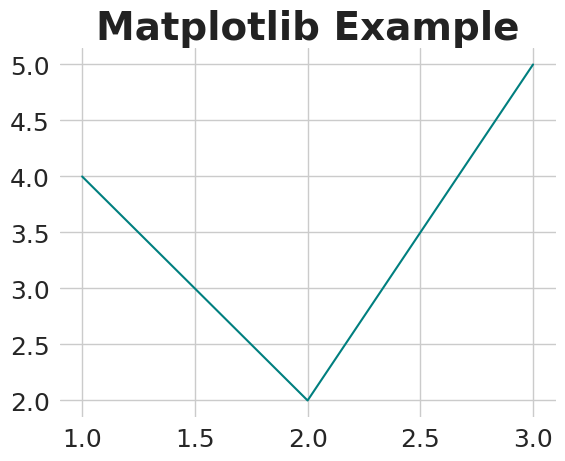

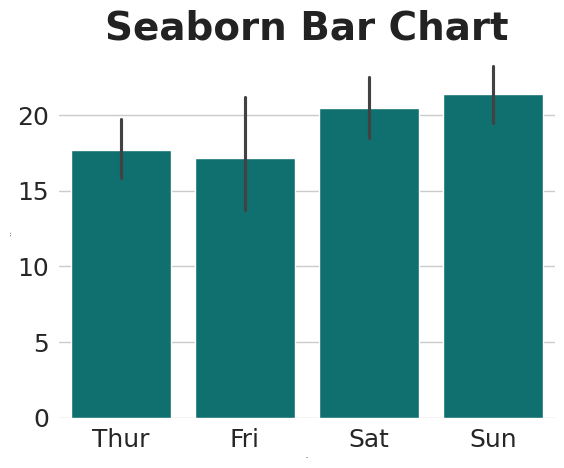

In [1]:
from bbcstyle.theme import bbc_theme
import matplotlib.pyplot as plt
import seaborn as sns

bbc_theme()

# Plot with matplotlib
plt.plot([1, 2, 3], [4, 2, 5])
plt.title("Matplotlib Example")
plt.show()

# Plot with seaborn
tips = sns.load_dataset("tips")
sns.barplot(x="day", y="total_bill", data=tips)
plt.title("Seaborn Bar Chart")
plt.show()


In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from adjustText import adjust_text
from typing import List, Optional
import requests
from io import StringIO

def load_pensions_data(url: str) -> pd.DataFrame:
    """
    Fetch the pensions CSV from the URL using a browser-like User-Agent,
    load it into a DataFrame, rename columns to country, pop_over65, gov_spending,
    and drop any rows where gov_spending is missing.
    """
    headers = {"User-Agent": "Mozilla/5.0"}
    response = requests.get(url, headers=headers)
    response.raise_for_status()
    df = pd.read_csv(StringIO(response.text))
    df.columns = ["country", "pop_over65", "gov_spending"]
    return df.dropna(subset=["gov_spending"])


def get_oecd_countries(wiki_url: str) -> List[str]:
    """
    Scrape the list of OECD member states from the Wikipedia page at wiki_url.
    It finds the first table whose first column is 'Current' and returns its entries.
    """
    tables = pd.read_html(wiki_url, match="Member country")
    # assume the first such table is the full members list
    oecd_df = tables[0]
    return oecd_df["Current members"].tolist()

import requests
from bs4 import BeautifulSoup
from typing import List

def get_oecd_countries(wiki_url: str) -> List[str]:
    """
    Fetch the list of OECD current member countries from the given Wikipedia URL.
    It locates the "Current members" section and parses the following bullet list to return each country name.
    """
    headers = {"User-Agent": "Mozilla/5.0"}
    response = requests.get(wiki_url, headers=headers)
    response.raise_for_status()

    soup = BeautifulSoup(response.text, "html.parser")
    # find the heading that contains "Current members"
    header = soup.find(lambda tag: tag.name in ["h2", "h3"] and "Current members" in tag.get_text())
    if header is None:
        raise ValueError("Could not find 'Current members' section on the page")

    # the list of countries should be the next <ul> after that header
    ul = header.find_next_sibling("ul")
    if ul is None:
        raise ValueError("Could not find the list under 'Current members'")

    return [li.get_text(strip=True) for li in ul.find_all("li")]


def prepare_plot_data(
    pensions_df: pd.DataFrame,
    oecd_countries: List[str],
    highlight_countries: List[str],
) -> pd.DataFrame:
    """
    Take the raw pensions DataFrame and:
      • compute the OECD average as a new row
      • bind it back to the original data
      • mark each row with a text style: 'bold' for Brazil,
        'italic' for OECD average, 'plain' otherwise
      • split into highlight vs background for later plotting
    """
    # compute OECD average
    mask = pensions_df["country"].isin(oecd_countries)
    oecd_avg = (
        pensions_df[mask]
        .agg({"pop_over65": "mean", "gov_spending": "mean"})
        .to_frame()
        .T
    )
    oecd_avg["country"] = "OECD average"
    df = pd.concat([pensions_df, oecd_avg], ignore_index=True)

    # annotate text style
    df["text_face"] = df["country"].map(
        lambda c: "bold" if c == "Brazil" else ("italic" if c == "OECD average" else "plain")
    )
    df["is_highlight"] = df["country"].isin(highlight_countries)
    return df


def plot_pensions(data: pd.DataFrame) -> None:
    """
    Create an FT-style scatter of gov_spending vs pop_over65,
    highlighting Brazil, a few key countries and the OECD average,
    with repelled labels and a dark background.
    """
    # color palette
    bgr = "#262a33"
    pink = "#ff0055"
    blue1 = "#0d64fc"
    bg_point = "#90aac6"
    grid_col = "#3e4046"
    text_grey = "#9b9da1"

    # split
    df_bg = data[~data["is_highlight"]]
    df_hl = data[data["is_highlight"]]

    fig, ax = plt.subplots(figsize=(10, 6), facecolor=bgr)
    ax.set_facecolor(bgr)

    # all background points
    ax.scatter(
        df_bg["pop_over65"],
        df_bg["gov_spending"],
        s=50,
        color=bg_point,
        alpha=0.4,
    )

    # specific highlight groups
    Brazil = data.query("country == 'Brazil'")
    ax.scatter(
        Brazil["pop_over65"],
        Brazil["gov_spending"],
        s=80,
        facecolors=blue1,
        edgecolors="white",
        linewidths=1,
        zorder=3,
    )
    pink_countries = ["France", "Italy", "Greece", "Japan"]
    pink_df = data[data["country"].isin(pink_countries)]
    ax.scatter(
        pink_df["pop_over65"],
        pink_df["gov_spending"],
        s=80,
        facecolors=pink,
        edgecolors="white",
        linewidths=1,
        zorder=3,
    )
    ax.scatter(
        data.query("country in ['United States', 'OECD average']").pop_over65,
        data.query("country in ['United States', 'OECD average']").gov_spending,
        s=50,
        color=pink,
        alpha=0.8,
        zorder=2,
    )
    ax.scatter(
        data.query("country in ['Mexico', 'Turkey']").pop_over65,
        data.query("country in ['Mexico', 'Turkey']").gov_spending,
        s=50,
        color=blue1,
        alpha=0.8,
        zorder=2,
    )

    # grid & axes
    ax.set_xlim(5, 30.5)
    ax.set_ylim(0, 20)
    ax.set_xticks(range(5, 31, 5))
    ax.set_yticks(range(0, 21, 5))
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    ax.grid(True, color=grid_col, linewidth=0.8)
    ax.grid(False, which="minor")
    ax.set_xlabel("Population aged 65 years and over, % of total", color=text_grey)
    ax.tick_params(colors=text_grey)
    ax.spines.values().__iter__().__next__().set_visible(False)

    # labels with nudges
    nudges = {
        "France": (0, 1),
        "Greece": (1.4, 0),
        "Italy": (0, 1),
        "Japan": (0, -0.8),
        "United States": (-2.4, 0),
        "OECD average": (-2.5, 0),
        "Brazil": (0, 1.1),
        "Turkey": (0, 0.9),
        "Mexico": (0, 0.9),
    }
    texts = []
    for _, row in df_hl.iterrows():
        dx, dy = nudges.get(row["country"], (0, 0))
        txt = ax.text(
            row["pop_over65"] + dx,
            row["gov_spending"] + dy,
            row["country"],
            family="Fira Sans Condensed",
            fontsize=10,
            fontweight="bold" if row["text_face"] == "bold" else "normal",
            fontstyle="italic" if row["text_face"] == "italic" else "normal",
            color="white" if row["country"] == "Brazil" else text_grey,
        )
        texts.append(txt)
    adjust_text(texts, ax=ax, arrowprops=dict(arrowstyle="-", color=bgr))

    # title, subtitle, caption
    fig.suptitle(
        "Brazil's golden oldie blowout",
        x=0.1,
        y=0.98,
        fontsize=18,
        fontweight="bold",
        family="Fira Sans Condensed",
        color="white",
    )
    ax.set_title(
        "Latest available",
        loc="left",
        pad=20,
        fontsize=13,
        family="Fira Sans Condensed",
        color=text_grey,
    )
    fig.text(
        0.01,
        0.02,
        "Source: OECD; World Bank; Previdência Social | Graphic Designer: Nguyen Chi Dung",
        fontsize=11,
        family="Fira Sans Condensed",
        color="#526171",
    )

    # FT‐style top‐left bar
    fig.patches.append(
        patches.Rectangle(
            (0.055, 0.995),
            width=0.05 * 1.7,
            height=0.008,
            transform=fig.transFigure,
            facecolor="white",
            edgecolor="white",
            clip_on=False,
        )
    )

    plt.tight_layout()
    plt.show()



pensions_url = "http://infographics.economist.com/databank/Economist_pensions.csv"
wiki_url = "https://en.wikipedia.org/wiki/OECD"
some_countries = [
    "Brazil", "Turkey", "Mexico", "Poland", "South Korea", "Italy",
    "United States", "France", "OECD average", "Japan", "Greece"
]

df_pensions = load_pensions_data(pensions_url)
oecd_list = get_oecd_countries(wiki_url)
df_plot = prepare_plot_data(df_pensions, oecd_list, some_countries)
plot_pensions(df_plot)


ValueError: Could not find the list under 'Current members'